<a href="https://colab.research.google.com/github/armangupta910/Movie-Recommendor-System/blob/main/Movie_Recommendation_using_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load data
def load_data():
    ratings = pd.read_csv("ratings.csv")
    movies = pd.read_csv("movies.csv")
    tags = pd.read_csv("tags.csv")
    links = pd.read_csv("links.csv")
    return ratings, movies, tags, links

# Content-based filtering
def content_based_filtering(movies, tags):
    # Merge movies and tags
    movie_tags = pd.merge(movies, tags, on='movieId', how='left')
    # Fill missing values
    movie_tags['tag'] = movie_tags['tag'].fillna('')
    # Group tags by movieId
    movie_tags_grouped = movie_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x))
    # Vectorize tags
    vectorizer = TfidfVectorizer()
    tag_matrix = vectorizer.fit_transform(movie_tags_grouped)
    return tag_matrix

# Collaborative filtering
def collaborative_filtering(ratings):
    # Pivot ratings dataframe
    user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=10, random_state=42)
    gmm.fit(user_movie_matrix)
    return gmm

# Movie recommendation
def recommend_movies(movie_id, movies, gmm, tag_matrix):
    # Get movie index
    movie_index = movies[movies['movieId'] == movie_id].index
    if len(movie_index) == 0:
        return None
    movie_index = movie_index[0]
    # Calculate cosine similarity between movie tags and all other movies
    similarities = cosine_similarity(tag_matrix, tag_matrix[movie_index])
    # Get top 10 similar movies
    similar_indices = similarities.flatten().argsort()[-11:-1]
    similar_movies = [(movies['title'][i], similarities[i][0]) for i in similar_indices]
    return similar_movies

# Main function
def main():
    # Load data
    ratings, movies, tags, links = load_data()
    # Content-based filtering
    tag_matrix = content_based_filtering(movies, tags)
    # Collaborative filtering
    gmm = collaborative_filtering(ratings)
    # Movie recommendation
    movie_id = 1  # Example movie ID
    recommended_movies = recommend_movies(movie_id, movies, gmm, tag_matrix)
    print("Recommended Movies for Movie ID", movie_id)
    for movie, similarity in recommended_movies:
        print(movie, "- Similarity:", similarity)

if __name__ == "__main__":
    main()


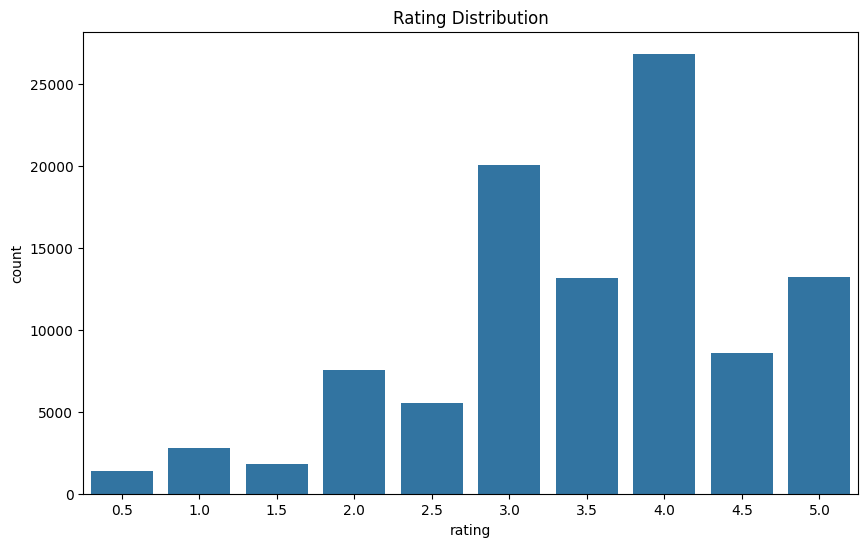

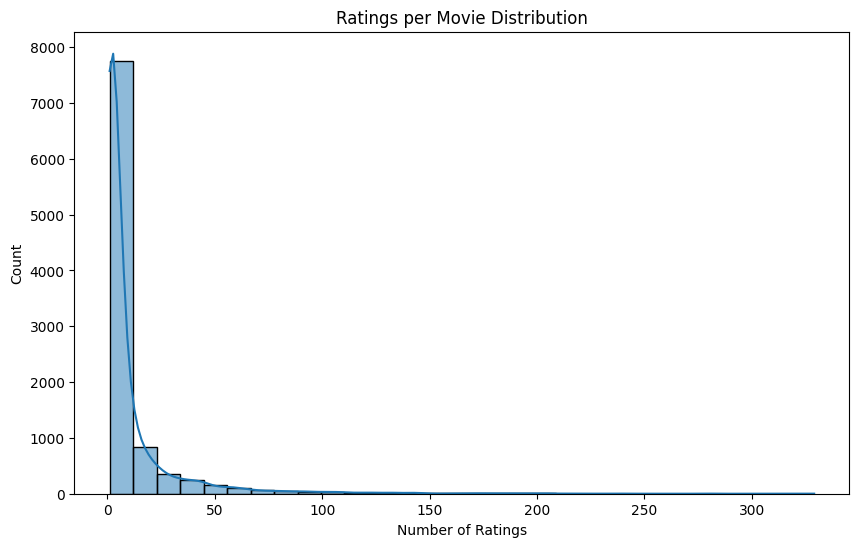

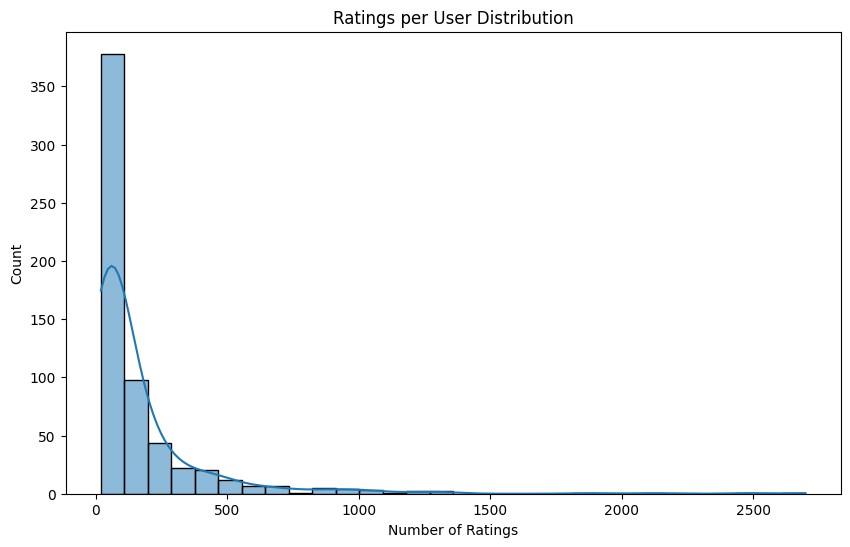

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error

# Data Cleaning and Preprocessing
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

# Handle missing values
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
tags.dropna(inplace=True)
links.dropna(inplace=True)

# Convert data types if necessary

# Removing duplicates
movies.drop_duplicates(inplace=True)
ratings.drop_duplicates(inplace=True)
tags.drop_duplicates(inplace=True)
links.drop_duplicates(inplace=True)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Rating Distribution')
plt.show()

# Compute number of ratings per movie and user
ratings_per_movie = ratings.groupby('movieId').size()
ratings_per_user = ratings.groupby('userId').size()

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=30, kde=True)
plt.title('Ratings per Movie Distribution')
plt.xlabel('Number of Ratings')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, kde=True)
plt.title('Ratings per User Distribution')
plt.xlabel('Number of Ratings')
plt.show()

# # Model Evaluation
# train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# # Hyperparameter Tuning
# param_grid = {
#     'n_components': [2, 5, 10, 20],  # Example values for number of components
#     'covariance_type': ['full', 'tied', 'diag', 'spherical']  # Different covariance types
# }

# gmm = GaussianMixture()

# grid_search = GridSearchCV(gmm, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(train[['userId', 'movieId']], train['rating'])

# best_model = grid_search.best_estimator_

# # # Evaluate best model
# # predictions = best_model.predict(test[['userId', 'movieId']])
# # rmse = np.sqrt(mean_squared_error(test['rating'], predictions))
# # print("RMSE:", rmse)

# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)


In [25]:
#Model Evaluation
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Hyperparameter Tuning
param_grid = {
    'n_components': [2, 5, 10, 20],  # Example values for number of components
    'covariance_type': ['full', 'tied', 'diag', 'spherical']  # Different covariance types
}

gmm = GaussianMixture()

grid_search = GridSearchCV(gmm, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train[['userId', 'movieId']], train['rating'])

best_model = grid_search.best_estimator_

# Evaluate best model
predictions = best_model.predict(test[['userId', 'movieId']])
rmse = np.sqrt(mean_squared_error(test['rating'], predictions))
print("RMSE:", rmse)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)


RMSE: 2.6302470650426377
Best Parameters: {'covariance_type': 'tied', 'n_components': 5}


In [20]:
# Model Training
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

gmm = GaussianMixture(n_components=10, random_state=42)  # Setting the number of components

gmm.fit(train[['userId', 'movieId']])

# Function to recommend movies to a user
def recommend_movies(user_id, model, n_recommendations=5):
    user_movies = ratings[ratings['userId'] == user_id]['movieId'].unique()
    all_movies = ratings['movieId'].unique()
    new_movies = list(set(all_movies) - set(user_movies))
    user_movie_pairs = [[user_id, movie] for movie in new_movies]
    ratings_pred = model.score_samples(user_movie_pairs)
    top_indices = sorted(range(len(ratings_pred)), key=lambda i: ratings_pred[i], reverse=True)[:n_recommendations]
    recommended_movies = [new_movies[i] for i in top_indices]
    return recommended_movies

# Recommending movies to a specific user (example user ID: 1)
user_id = 1
recommendations = recommend_movies(user_id, gmm, n_recommendations=5)

# Displaying recommended movies
print("Top 5 Recommended Movies for User", user_id, ":")
for movie_id in recommendations:
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print("-", movie_title)


Top 5 Recommended Movies for User 1 :
- Akira (1988)
- Down by Law (1986)
- Patton (1970)
- Cool Hand Luke (1967)
- Fried Green Tomatoes (1991)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Evaluate best model
predictions = best_model.predict(test[['userId', 'movieId']])
rmse = np.sqrt(mean_squared_error(test['rating'], predictions))

# Calculate the range of ratings
rating_range = test['rating'].max() - test['rating'].min()

# Calculate RMSE as a percentage of the rating range
rmse_percentage = (rmse / rating_range) * 100
print("RMSE:", rmse)
print("RMSE Percentage:", rmse_percentage, "%")



RMSE: 3.3547837602067476
RMSE Percentage: 74.5507502268166 %
